# COMP0036 Group Assignment: BEAT THE BOOKIE

### Group N

We have been assigned to build model(s) that predict the FTR value, which can be Home Win (H), Draw (D) and Away Win (A). The general steps we will be taking to build the model(s) begins with finding a suitable dataset and performing feature engineering on the selected features to be used in the model. This entails creating functions or classes to convert the raw data and transforms it into a format where every match has that historic feature. Then, we perform feature selection to filter out unimportant features, and use the selected features in model(s), and then compare and decide the best performing model. Finally, improve models to get the best accuracy.

In [ ]:
!pip3 install matplotlib==3.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
import numpy as np

# not import for now since tf not working on mine Mac rn
#import tensorflow as tf

from calendar import month_name
import seaborn as sns
from pandas.core.common import random_state

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from numpy import mean
from numpy import std
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from datetime import datetime

from matplotlib import pyplot as plt

Load training data

In [ ]:
dirName_trainData = 'https://raw.githubusercontent.com/shabir-dhillon/GCW_0036/main/Group%20Coursework%20Brief-20221106/Data_Files/epl-full-training.csv'

dirName_rankingData = 'https://raw.githubusercontent.com/shabir-dhillon/GCW_0036/main/Group%20Coursework%20Brief-20221106/Data_Files/EPL%20Standings%202000-2022.csv'

### Auxiliary functions

In [ ]:
# Used for summary part of each feature Set
model_acc_dict = {
  'RG': 0,
  'DT': 0,
  'RF': 0,
  'KNN': 0,
  'SVM': 0,
  'XGB': 0,
  'NN': 0
}

In [ ]:
def summary_hist(model_acc_dict=model_acc_dict, title="Summary of Models - Feature Set 1", fig_size=(9, 9)):
  model_names = model_acc_dict.keys()
  model_names = ["Random Guess", "Decision Tree", 
                  "Random Forest", "K Nearest Neighbors",
                  "Support Vector Machine", "XGB",
                  "Nerual Network"]
  
  x_label = "Accuracy (%)"
  y_label = "Models trained"

  accs = model_acc_dict.values()

  fig = plt.figure(figsize=fig_size)
  ax = fig.gca()
  p1 = ax.barh(model_names, accs)

  ax.set_title(title, fontsize=12)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)

  for i, v in enumerate(accs):
      ax.text(v//2, i, str(v), color='white', fontsize=9, ha='left', va='center')

  fig.tight_layout()
  plt.show()


In [ ]:
'''
Function used to plot changes on training loss & cross validation loss
'''
def plot_train_test_acc(results , scoring, param_x = "param_max_depth",title="GridSearchCV evaluation", xlabel="max_depth", ylabel="Score",xlim=(0,100), ylim=(0.4,1), fig_size=(9, 9)):

    # REF:https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
    plt.figure(figsize=fig_size)
    plt.title(title, fontsize=16)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    ax = plt.gca()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results[param_x].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ["g", "k"]):
        for sample, style in (("train", "--"), ("test", "-")):
            sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
            sample_score_std = results["std_%s_%s" % (sample, scorer)]
            ax.fill_between(
                X_axis,
                sample_score_mean - sample_score_std,
                sample_score_mean + sample_score_std,
                alpha=0.1 if sample == "test" else 0,
                color=color,
            )
            # change label(test) -> cross validation to avoid confusion
            if sample == "test":
              sample = "cross validation"
            ax.plot(
                X_axis,
                sample_score_mean,
                style,
                color=color,
                alpha=1 if sample == "cross validation" else 0.7,
                label="%s (%s)" % (scorer, sample),
            )

        best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
        best_score = results["mean_test_%s" % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot(
            [
                X_axis[best_index],
            ]
            * 2,
            [0, best_score],
            linestyle="-.",
            color=color,
            marker="x",
            markeredgewidth=3,
            ms=8,
        )
    
        # Annotate the best score for that scorer
        ax.annotate("%0.4f" % best_score, (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

### OPTIMIZATION & Cross Validation (TODO: Check content with others)

* For every Feature set, we try the following classifiers
    - Decision Tree
    - Random Forest
    - K-Nearest Neighbours (KNN)
    - Support Vector Machine
    - XGBOOST [NOT IN NOTEBOOK YET]
    - NN [NOT IN NOTEBOOK YET]
- Linear Regreesion (Only used when prdicting the result goals)

In [ ]:
"""
NOTE: Scoring metrics
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
"""
scoring = {"Accuracy": "accuracy"}
cv = KFold(n_splits=5, random_state=42, shuffle=True)

#### Decision Tree

In [ ]:
"""Decision Tree"""
def fit_DT(X, y):
    """ Parameters can be tweaked for regularization (more options see sklearn documentation)
    {'ccp_alpha': 0.0,
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': None,
    'max_features': None,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'random_state': None,
    'splitter': 'best'}
    """
 
    classifier = DecisionTreeClassifier(random_state=42)
    print(list(np.linspace(1, X.shape[1], X.shape[1]//5, dtype=int)))
    param_grid = {'max_depth': list(np.linspace(1, X.shape[1], X.shape[1]//5, dtype=int)),
                  'max_features': list(np.linspace(1, X.shape[1], X.shape[1]//5, dtype=int))}
    # NOTE: more option eg. custom scoring metric avaliable -> see sklearn doc
    # n_jobs used for optimization (use all processor)
    # verbose -> display detail (0,1,>1) higher -> more detailed
    grid = GridSearchCV(
        classifier, 
        param_grid=param_grid, 
        cv=cv, 
        verbose=1, 
        n_jobs=-1, 
        scoring=scoring, 
        return_train_score=True,
        refit="Accuracy")
    clf = grid.fit(X, y)

    return clf

#### Random Forest

In [ ]:
def fit_RF(X, y):
    """ Parameters can be tweaked for regularization (more options see sklearn documentation)
    {'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': None,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 100,
    'n_jobs': None,
    'oob_score': False,
    'random_state': None,
    'verbose': 0,
    'warm_start': False}
    """
    
    classifier = RandomForestClassifier(random_state=42)
    param_grid = {'max_depth':list(np.linspace(1, X.shape[1], X.shape[1]//5, dtype=int)),
                  'max_features': list(np.linspace(1, X.shape[1], X.shape[1]//5, dtype=int))}
    # NOTE: more option eg. custom scoring metric avaliable -> see sklearn doc
    # n_jobs used for optimization (use all processor)
    # verbose -> display detail (0,1,>1) higher -> more detailed
    grid = GridSearchCV(
        classifier, 
        param_grid=param_grid, 
        cv=cv, 
        verbose=1, 
        n_jobs=-1, 
        scoring=scoring, 
        return_train_score=True,
        refit="Accuracy")
    clf = grid.fit(X, y)

    return clf

#### K-Nearest Neighbours (KNN)

In [ ]:
def fit_KNN(X, y):
    """ Parameters can be tweaked for regularization (more options see sklearn documentation)
    {'algorithm': 'auto',
    'leaf_size': 30,
    'metric': 'minkowski',
    'metric_params': None,
    'n_jobs': None,
    'n_neighbors': 5,
    'p': 2,
    'weights': 'uniform'}
    """
    classifier = KNeighborsClassifier()
    # Only tweaked the depth here as an example
    param_grid = {'n_neighbors':list(np.linspace(3, 10, 2, dtype=int))}
    # NOTE: more option eg. custom scoring metric avaliable -> see sklearn doc
    # n_jobs used for optimization (use all processor)
    # verbose -> display detail (0,1,>1) higher -> more detailed
    grid = GridSearchCV(
        classifier, 
        param_grid=param_grid, 
        cv=cv, 
        verbose=1, 
        n_jobs=-1, 
        scoring=scoring, 
        return_train_score=True,
        refit="Accuracy")
    clf = grid.fit(X, y)

    return clf

#### Support Vector Machine (SVM)

In [ ]:
def fit_SVM(X, y):
    """ Parameters can be tweaked for regularization (more options see sklearn documentation)
    {'C': 1.0,
    'break_ties': False,
    'cache_size': 200,
    'class_weight': None,
    'coef0': 0.0,
    'decision_function_shape': 'ovr',
    'degree': 3,
    'gamma': 'scale',
    'kernel': 'rbf',
    'max_iter': -1,
    'probability': False,
    'random_state': None,
    'shrinking': True,
    'tol': 0.001,
    'verbose': False}
    """
    classifier = svm.SVC()
    # Only tweaked the depth here as an example
    param_grid = {'C':[1.0,5.0,10.0,15.0, 20.0, 25.0, 30.0]
                  }
    # NOTE: more option eg. custom scoring metric avaliable -> see sklearn doc
    # n_jobs used for optimization (use all processor)
    # verbose -> display detail (0,1,>1) higher -> more detailed
    grid = GridSearchCV(
        classifier, 
        param_grid=param_grid, 
        cv=cv, 
        verbose=1, 
        n_jobs=-1, 
        scoring=scoring, 
        return_train_score=True,
        refit="Accuracy")
    clf = grid.fit(X, y)

    return clf

## Data Analysis 

In [ ]:
df_epl = pd.read_csv(dirName_trainData)
df_ranking = pd.read_csv(dirName_rankingData)

def get_season_start_date(date):
    if date.month <= 7:
        return datetime(date.year-1, 8, 1)
    return datetime(date.year-0, 8, 1)

df_epl['HomeStanding_PrevSeason'] = np.zero(df_epl.shape[0])
df_epl['AwayStanding_PrevSeason'] = np.zero(df_epl.shape[0])
df_epl['DiffStanding_PrevSeason'] = np.zero(df_epl=pd.merge(df_epl, df_ranking, on="B", how="outer")
                                            df_epl.shape[0])

homeTeamRankings = []
awayTeamRankings = []
diffRankings = []

for index, row in df_epl.iterrows():
      season = get_season_start_date(row["Date"])
      season = str(season) + "-" + str(season+1)[:-2] # from df_ranking
      homeTeam = row["HomeTeam"]    
      awayTeam = row["AwayTeam"]
      homeRanking = df_ranking[df_ranking['']]['Pos'] #filter dataframe ranking for year=season and hometeam=homeTeam
      awayRanking = df_ranking[df_ranking['']]['Pos'] #filter dataframe ranking for year=season and awayTeam=awayTeam

      

# df_epl.assign(newid=f(df_epl['date']))



cols = ["Div","Date","HomeTeam","AwayTeam","FTHG", "FTAG","FTR","HTHG","HTAG","HTR","HS","AS", "HST","AST","HF","AF","HC","AC","HY","AY","HR","AR"]

df_epl = df_epl.loc[:, cols]
df_epl = df_epl.reset_index(drop=True)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_epl.head())

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,E0,17/08/2002,Blackburn,Sunderland,0,0,D,0,0,D,15,7,5,3,14,11,9,1,1,2,0,0
1,E0,17/08/2002,Charlton,Chelsea,2,3,A,2,1,H,5,21,5,12,10,12,3,6,0,3,1,0
2,E0,17/08/2002,Everton,Tottenham,2,2,D,1,0,H,13,10,9,5,18,4,10,5,1,1,0,0
3,E0,17/08/2002,Fulham,Bolton,4,1,H,3,1,H,13,3,6,1,16,12,7,4,1,2,0,0
4,E0,17/08/2002,Leeds,Man City,3,0,H,2,0,H,13,18,8,10,13,13,2,7,1,1,0,0


Here is a breakdown of the initial features we have from our dataset:

Div = League Division

Date = Match Date (dd/mm/yy)

HomeTeam = Home Team

AwayTeam = Away Team

FTHG = Full Time Home Team Goals

FTAG = Full Time Away Team Goals

FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)

HTHG = Half Time Home Team Goals

HTAG = Half Time Away Team Goals

HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)

HS = Home Team Shots

AS = Away Team Shots

HST = Home Team Shots on Target

AST = Away Team Shots on Target

HF = Home Team Fouls Committed

AF = Away Team Fouls Committed

HC = Home Team Corners

AC = Away Team Corners

HY = Home Team Yellow Cards

AY = Away Team Yellow Cards

HR = Home Team Red Cards

AR = Away Team Red Cards

*TODO @Andrzej add category encoder to team names*

In [ ]:
# Transform the date column from strings into datetime objects
df_epl["Date"] = pd.to_datetime(df_epl["Date"], dayfirst=True)
# Turn the catergorical data into labels using same method from before
df_epl["AwayTeam_Enc"] = df_epl["AwayTeam"].astype("category").cat.codes
df_epl["HomeTeam_Enc"] = df_epl["HomeTeam"].astype("category").cat.codes
df_epl = df_epl.drop(['HomeTeam', 'AwayTeam', 'Div'], axis=1)
# Transform the date column into day and month columns and Add into dataframe (Extract days & months from date)
df_epl["Date"] = pd.to_datetime(df_epl["Date"])
df_epl["Day"] = df_epl["Date"].dt.day
df_epl["Month"] = df_epl["Date"].dt.month 
df_epl["Year"] = df_epl["Date"].dt.year

In [ ]:
df_epl.head()

,Date,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,...,AC,HY,AY,HR,AR,AwayTeam_Enc,HomeTeam_Enc,Day,Month,Year
0,2002-08-17,0,0,D,0,0,D,15,7,5,...,1,1,2,0,0,34,3,17,8,2002
1,2002-08-17,2,3,A,2,1,H,5,21,5,...,6,0,3,1,0,12,11,17,8,2002
2,2002-08-17,2,2,D,1,0,H,13,10,9,...,5,1,1,0,0,36,15,17,8,2002
3,2002-08-17,4,1,H,3,1,H,13,3,6,...,4,1,2,0,0,5,16,17,8,2002
4,2002-08-17,3,0,H,2,0,H,13,18,8,...,7,1,1,0,0,22,19,17,8,2002


Let's visualize the dataset and common more and less obvious trends in it.

First of all, let's check if the classification problem can be considered balanced by plotting a histogram of classification labels.

<AxesSubplot:xlabel='FTR', ylabel='Count'>

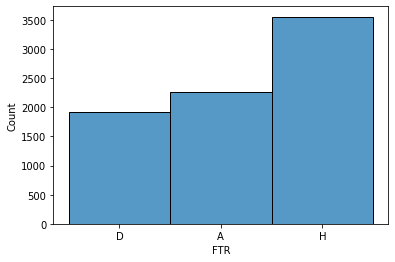

In [ ]:
sns.histplot(df_epl, x='FTR')

We've got visibly more home team wins, this may indicate that if a team plays at home, it has more chances of winning a game. Let's see if playing as a home team gives better scores in other features. 

In [ ]:
describe_df = df_epl.describe()

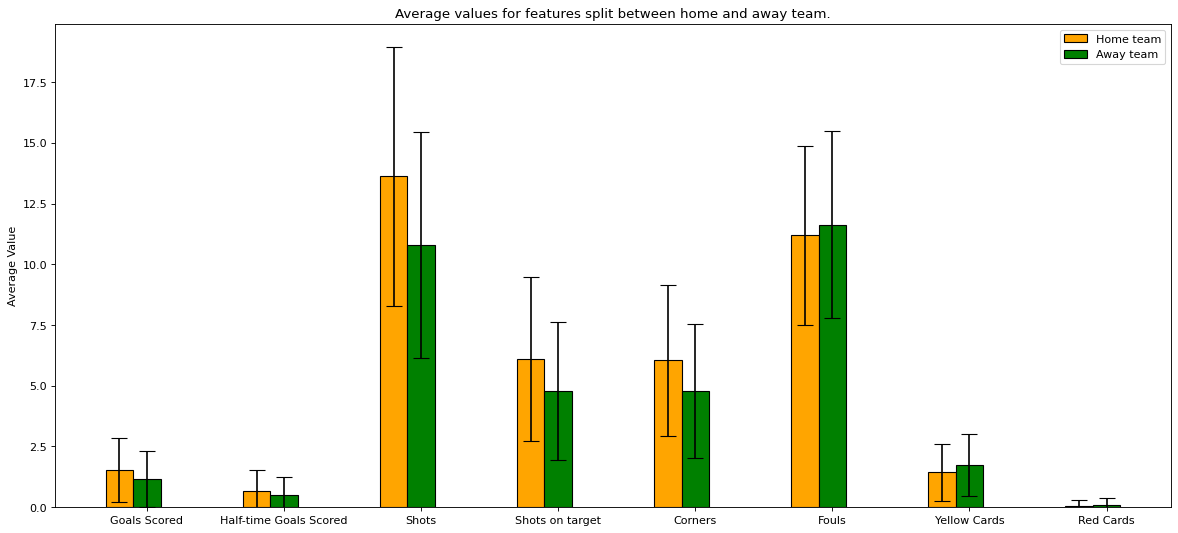

In [ ]:
# Graph inspired by https://armantee.github.io/predicting/

home_features = ['FTHG','HTHG','HS','HST','HC','HF','HY','HR']
away_features = ['FTAG','HTAG','AS','AST','AC','AF','AY','AR']
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')

# width of the bars
barWidth = 0.2
bars1 = np.array(describe_df.iloc[1, :][home_features]).flatten()
bars2 = np.array(describe_df.iloc[1, :][away_features]).flatten()
yer1 = np.array(describe_df.iloc[2, :][home_features]).flatten()
yer2 = np.array(describe_df.iloc[2, :][away_features]).flatten()
# The x position of bars
r1 = np.arange(len(bars1.flatten()))
r2 = [x + barWidth for x in r1]
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer1, capsize=7, label='Home team')
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'green', edgecolor = 'black', yerr=yer2, capsize=7, label='Away team')
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['Goals Scored', 'Half-time Goals Scored', 'Shots','Shots on target', 'Corners','Fouls','Yellow Cards','Red Cards'])
plt.ylabel('Average Value')
plt.ylim(0)
plt.title("Average values for features split between home and away team.")
plt.legend()
# Show graphic
plt.show()

*TODO @Andrzej - write that shots and goals may have significant meaning as features.*

This reveals that teams playing home have higher probability of winning. Let's see how the number of matches won by a team changes across years.



In [ ]:
year_dict = []
for i in range(2002, 2023):
    grouped_wins = df_epl[(df_epl['FTR'] == 'H') & (df_epl['Year'] == i)].groupby('HomeTeam_Enc')
    grouped_all = df_epl[(df_epl['Year'] == i)].groupby('HomeTeam_Enc')
    
    year_dict.append(dict(grouped_wins['FTR'].count()/grouped_all['FTR'].count()))

def get_team_stats(team_no):
    team = []
    for year in range(len(year_dict)):
        try:
            value = year_dict[year][team_no]
            if np.isnan(value):
                value = 0
        except KeyError:
            value = 0
        team.append(value)
    return team

*TODO @Andrzej - Worth adding team names instead of numbers. This requires using an encoder in one of the first steps!*

[]

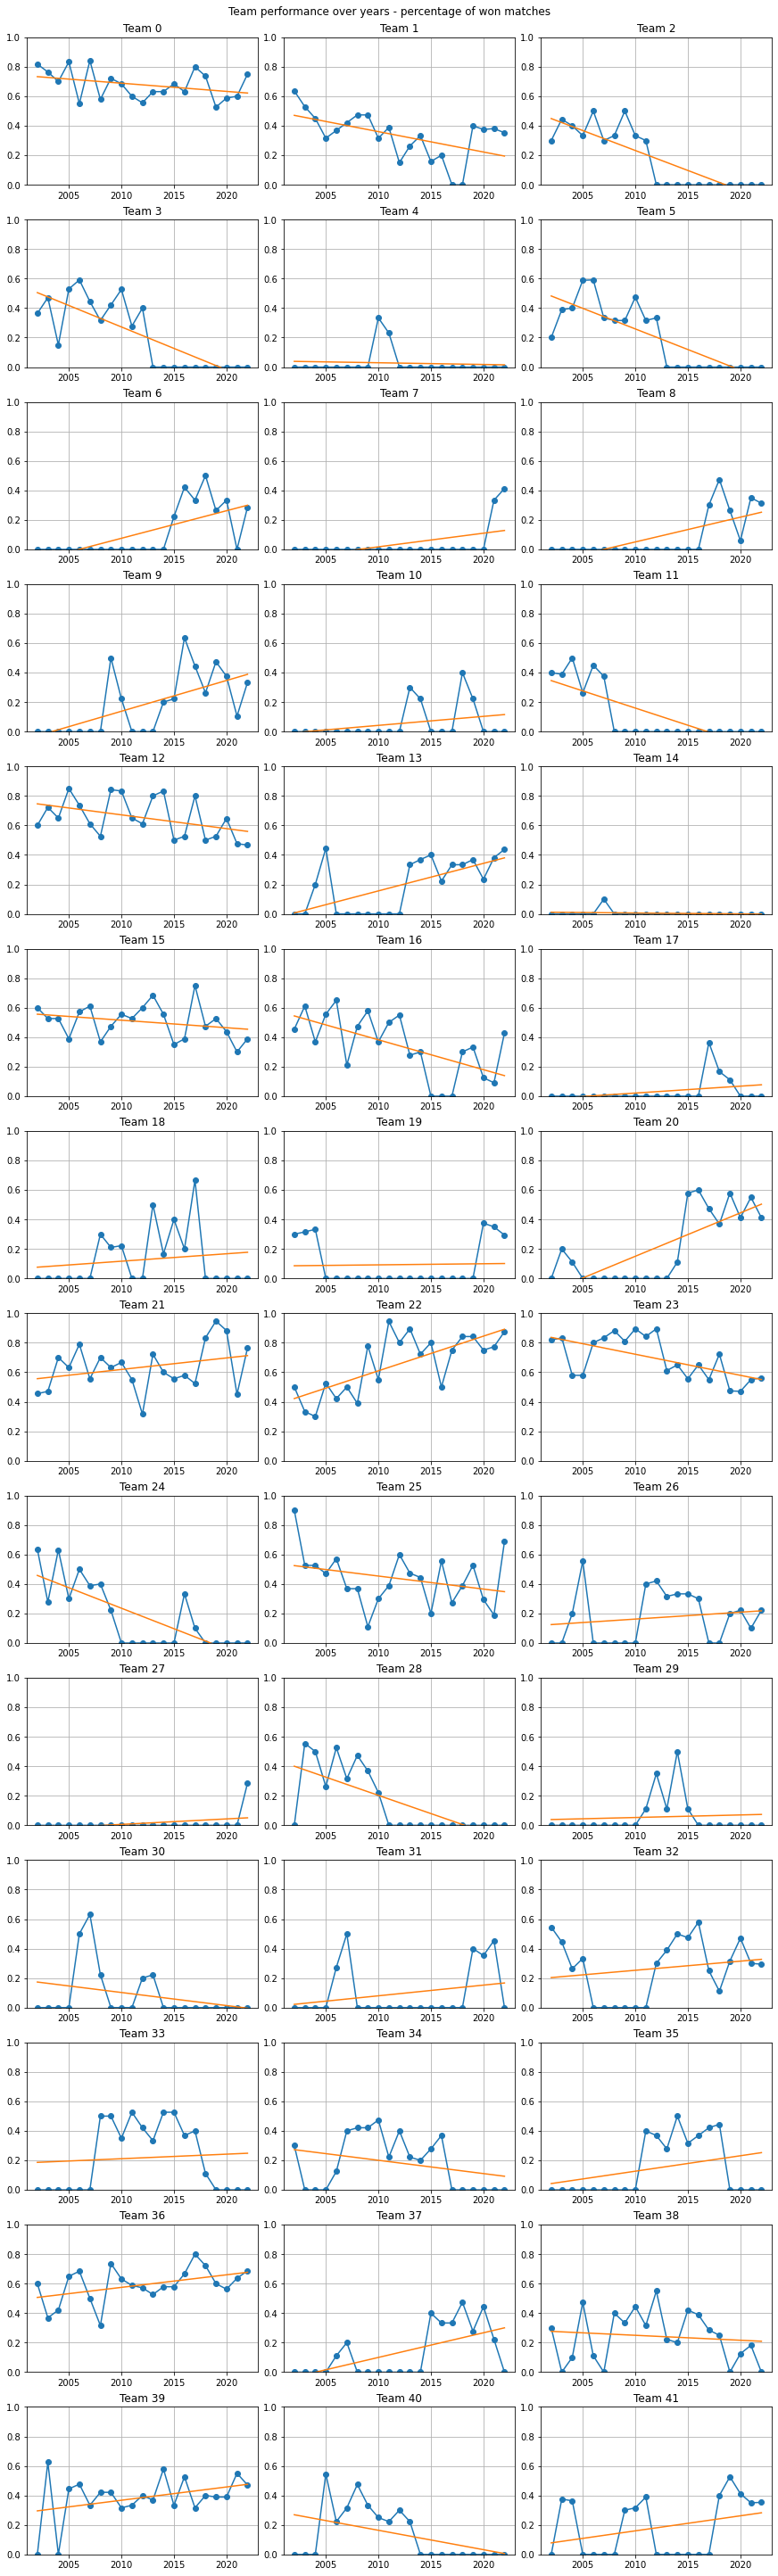

In [ ]:
fig, ax = plt.subplots(14, 3, figsize=(12, 40), constrained_layout=True)

for i in range(df_epl['HomeTeam_Enc'].nunique()):
    ax[i//3][i%3].set_title(f'Team {i}')
    ax[i//3][i%3].grid()
    # ax[i//3][i%3].set_xticks(np.arange(2002, 2023, step=1))
    ax[i//3][i%3].set_ylim(ymin=0)
    y = get_team_stats(i)
    x = np.array((range(2002, 2023)))
    a, b = np.polyfit(x, y, 1)
    ax[i//3][i%3].plot(x, y, '-o')
    ax[i//3][i%3].plot(x, a*x+b)
fig.suptitle("Team performance over years - percentage of won matches")
plt.plot()

Let's see if a month has an influence on a match outcome.

In [ ]:
counts = {}
month_names = {}
for month in range(1, 13):
    h = 100 * len(df_epl[(df_epl['Month'] == month) & (df_epl['FTR'] == 'H')])/len(df_epl[(df_epl['Month'] == month)])
    d = 100 * len(df_epl[(df_epl['Month'] == month) & (df_epl['FTR'] == 'D')])/len(df_epl[(df_epl['Month'] == month)])
    a = 100 * len(df_epl[(df_epl['Month'] == month) & (df_epl['FTR'] == 'A')])/len(df_epl[(df_epl['Month'] == month)])
    counts[month_name[month]] = [h, a, d]

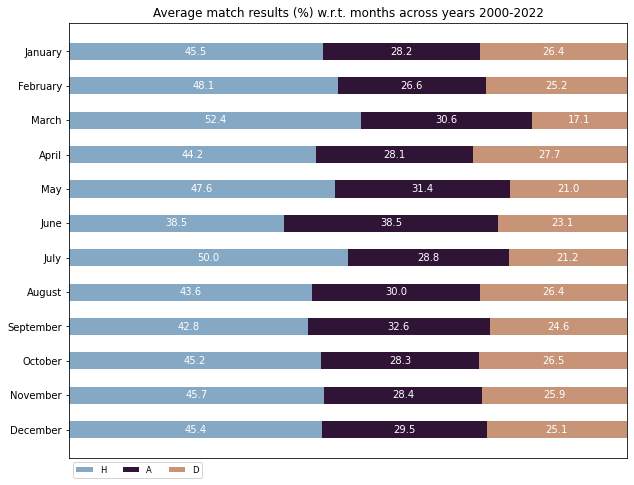

In [ ]:
# inspired by https://matplotlib.org/stable/gallery/lines_bars_and_markers/horizontal_barchart_distribution.html#sphx-glr-gallery-lines-bars-and-markers-horizontal-barchart-distribution-py

category_names = ['H', 'A', 'D']
results = counts

labels = list(results.keys())
data = np.array(list(results.values()))
data_cum = data.cumsum(axis=1)
category_colors = plt.colormaps['twilight'](
    np.linspace(0.15, 0.85, data.shape[1]))

fig, ax = plt.subplots(figsize=(10, 8))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data, axis=1).max())

for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    rects = ax.barh(labels, widths, left=starts, height=0.5,
                    label=colname, color=color)

    r, g, b, _ = color
    text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    ax.bar_label(rects, label_type='center', fmt='%.1f', color=text_color)
    
ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 0),
            loc='upper left', fontsize='small')
plt.title("Average match results (%) w.r.t. months across years 2000-2022")
plt.show()

In general, it looks like results across months are the similar, apart from June/July and March. This may be the outcome of much less matches being played during those months. Let's investigate this.

<AxesSubplot:xlabel='Month', ylabel='Count'>

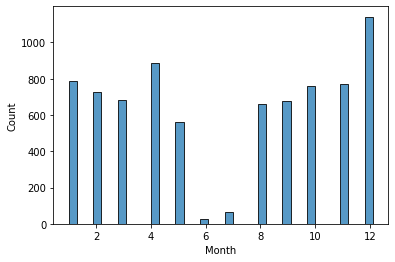

In [ ]:
sns.histplot(data=df_epl, x='Month', binwidth=0.3)

It looks like there are almost no matches played during early summer!

## Feature Engineering & Models

### **METHOD & EVALUATION**

First we start by reading the full (training) dataset (csv file) into a pandas dataframe, this allows us to easily manipulate, clean and encode the data as required. Next, using various functions we use the data in the dataframe to generate new features for each data point. These new generates features are then added back to the dataframe. Finally to create our design matrix we extract the relevant feature columns we require using the .loc method. We also create the output y vector by extracting the encoded FTR values. We then use this matrix and vector to input to different classifiers to see how they perform. In the results section we compare the performance of each classifier and provide brief explanations of why the result might be what they are and how we aim to improve them.

In [ ]:
def evaluate_report(y_pred, y_test):
  print("Accuracy: ", accuracy_score(y_test,y_pred))
  # handle f1 score zero division
  # https://stackoverflow.com/questions/62326735/metrics-f1-warning-zero-division
  print(classification_report(y_test, y_pred, zero_division=0))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### **FEATURE SET 1** - Baseline Classifier: Random Guesses

*SUMMARY ->* Custom random guess classifier implementation below. To ensure convenience it is compatibile with some *sklearn* functions.



In [ ]:
class RandomGuessClassifier(BaseEstimator, ClassifierMixin):
    """Custom implementation of the random guess classifier. 
    
    Compatible with sklearn.metric.plot_confusion_matrix function.
    """
    def __init__(self) -> None:
        self._labels: np.ndarray = None

    def fit(self, x_train: np.ndarray, y_train: np.ndarray) -> None:
        """Does not use x_train at all (who would actually want to use it lol). 
        Saves available labels from y_train.
        """
        self._labels = np.unique(y_train)

    def predict(self, x_test: np.ndarray) -> np.ndarray:
        """For every sample in x_test, chooses a label from self._labels at random"""
        return np.array(list(map(lambda _: np.random.choice(self._labels, 1), x_test)))

In [ ]:
def create_design_matrix(df):
  df_epl_final2 = df_epl.loc[:,['HomeTeam_Enc', 'AwayTeam_Enc']].values
  return df_epl_final2

def create_df(df_epl):
  return df_epl.copy()

df_final = create_df(df_epl)
X = create_design_matrix(df_final)
y = df_final.loc[:,['FTR']].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy:  0.32558139534883723
              precision    recall  f1-score   support

           A       0.25      0.29      0.27       429
           D       0.25      0.36      0.29       382
           H       0.48      0.33      0.39       737

    accuracy                           0.33      1548
   macro avg       0.33      0.33      0.32      1548
weighted avg       0.36      0.33      0.33      1548



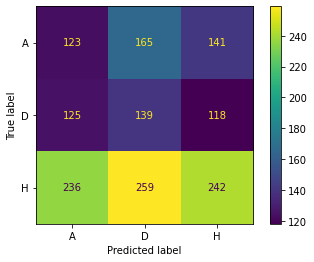

In [ ]:
rgc = RandomGuessClassifier()
rgc.fit(X_train, y_train)
y_pred = rgc.predict(X_test)

evaluate_report(y_pred, y_test)
model_acc_dict['RG'] = round(accuracy_score(y_test,y_pred)*100, 2)

### **FEATURE SET 2** - Simple: (HomeTeam, AwayTeam and Month) 

*SUMMARY ->* Firstly, we trained models only using the home team, away team and month as feature set. We evaluated and compared these models.
Since these models have not lead to great accuracies, we did not perform model selection on them. As the models become more complex (and include more features) we start to include the results from model selection.

(NOTE: We have also tried variations of this MODEL - with other basic features like day and referee added)

#### Create Dataframe and Design Matrix


In [ ]:
def create_df(df_epl):
  return df_epl.copy()

def create_design_matrix(df):
  X = df.loc[:,['HomeTeam_Enc', 'AwayTeam_Enc', 'Month']].values
  return X

df_final = create_df(df_epl)
X = create_design_matrix(df_final)
y = df_final.loc[:,['FTR']].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
# Check shape of y_train and y_test

FTR_encoder = LabelEncoder()
y_train = FTR_encoder.fit_transform(y_train);


3 0
[]
[]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Decision Tree Classifier

Accuracy:  0.4114987080103359
              precision    recall  f1-score   support

           A       0.36      0.47      0.41       429
           D       0.26      0.23      0.24       382
           H       0.54      0.47      0.50       737

    accuracy                           0.41      1548
   macro avg       0.39      0.39      0.38      1548
weighted avg       0.42      0.41      0.41      1548



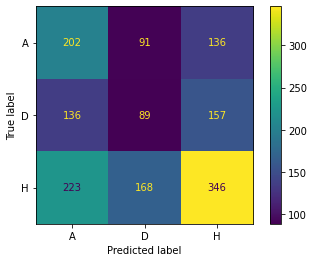

In [ ]:
# Create an empty Tree model
dt = DecisionTreeClassifier(random_state=42)
# Fit the model using training data
dt.fit(X_train, y_train)
# Make predictions using the model we have created
y_pred = dt.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['DT'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### Random Forest

Accuracy:  0.437984496124031
              precision    recall  f1-score   support

           A       0.37      0.37      0.37       429
           D       0.26      0.21      0.23       382
           H       0.54      0.60      0.56       737

    accuracy                           0.44      1548
   macro avg       0.39      0.39      0.39      1548
weighted avg       0.42      0.44      0.43      1548



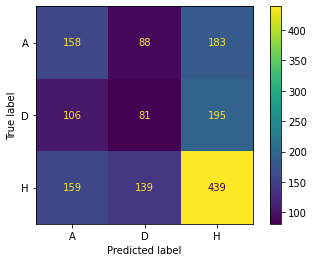

In [ ]:
# Create an empty Random Forest model
rf = RandomForestClassifier(random_state=42)
# Fit the model using training data
rf.fit(X_train, y_train)
# Make predictions using the model we have created
y_pred = rf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['RF'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### K-Nearest Neighbours (KNN)

Accuracy:  0.4186046511627907
              precision    recall  f1-score   support

           A       0.35      0.46      0.40       429
           D       0.26      0.20      0.23       382
           H       0.54      0.50      0.52       737

    accuracy                           0.42      1548
   macro avg       0.39      0.39      0.38      1548
weighted avg       0.42      0.42      0.42      1548



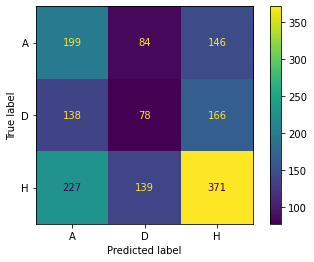

In [ ]:
# Create an empty KNN model
knn = KNeighborsClassifier()
# Fit the model using training data
knn.fit(X_train, y_train)
# Make predictions using the model we have created
y_pred = knn.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['KNN'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### Summary of Results

@TODO: Add summary text -> Adam

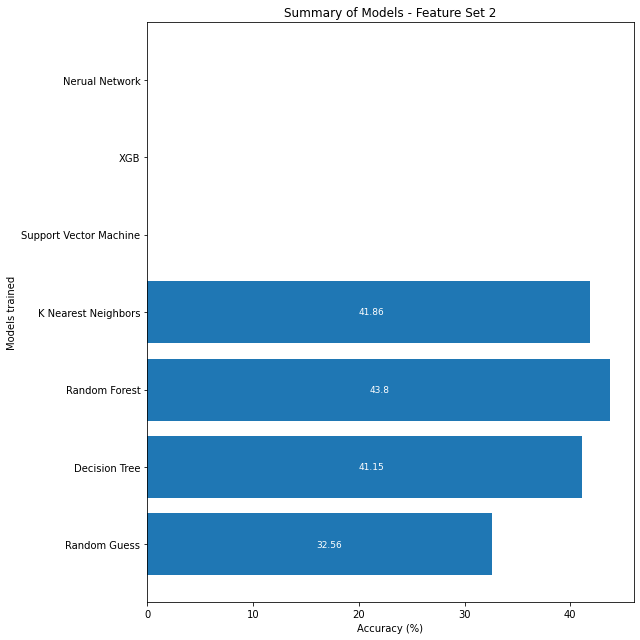

In [ ]:
summary_hist(title="Summary of Models - Feature Set 2", fig_size=(9, 9))

### **FEATURE SET 3** – Included averages of match statistics between the two specific target teams across all historical data

*SUMMARY ->* Here we aim to improve our previous score by adding some extra features. We use the same features from the previous section: date, HomeTeam and AwayTeam, BUT now we also add some averages of past stats between the specific two teams in question. We obtain these stats by filtering the df_epl dataframe for matches between HomeTeam and AwayTeam that took place before the input date. Then take an average of the columns (with stats) like HR, AR, etc. This will provide us with the average past stats for games played in past between the two teams. We can then use these values as extra features to input into the classifier.

#### Create Dataframe and Design Matrix

In [ ]:
# This function will take as input a date, HomeTeam and AwayTeam and output a 
# filtered dataframe where the matches shown are played before input data and 
# match is between HomeTeam and AwayTeam
def filter_dataframe(date, HomeTeam, AwayTeam, df):
    # Filter the dataframe to include only rows where Date
    df_epl_train_filtered = df.copy()
    df_epl_train_filtered = df_epl_train_filtered[(df.Date<date) & (df.HomeTeam_Enc==HomeTeam) & (df.AwayTeam_Enc==AwayTeam)]

    # Return filtered dataframe
    return df_epl_train_filtered

# This function takes as input the filtered dataframe from previous cell, 
# features to average and a dictionary, it then appends an average of each 
# feature to the dictionary
def average_columns(features, avg_features, filtered_df):
    for feature in features:
        df_col_means = filtered_df[feature].mean()
        avg_features[feature].append(df_col_means)


def create_df(df_epl):
  df_final = df_epl.copy()
  # Run the two functions for each row of our df_epl_train dataframe to fill 
  # dictionary with AVG for each match
  # NOTE: Some matches won't have past stats since the two teams may not have 
  # played against each other in past or we might not have the data

  # These are the features we want to get averages for
  features = ["FTHG","FTAG","HTHG","HTAG","HS","AS","HST","AST","HF","AF","HC","AC","HY","AY","HR","AR"]
  avg_features = {
                      "FTHG": [],
                      "FTAG": [],
                      "HTHG": [],
                      "HTAG": [],
                      "HS"  : [],
                      "AS"  : [],
                      "HST" : [],
                      "AST" : [],
                      "HF"  : [],
                      "AF"  : [],
                      "HC"  : [],
                      "AC"  : [],
                      "HY"  : [],
                      "AY"  : [],
                      "HR"  : [],
                      "AR"  : []
                  }

  # Run the two functions on each row of the df_epl_train and fill the dictionary
  # For each row in the dataframe
  for index, row in df_final.iterrows():
      # Filter the dataframe to only show matches played between those teams and before the certain date
      df_epl_train_filtered = filter_dataframe(row["Date"], row["HomeTeam_Enc"], row["AwayTeam_Enc"], df_final)
      # Get averages from the filtered dataframe and add the the dictionary
      average_columns(features, avg_features, df_epl_train_filtered)
  # Add a column for each of these feature averages using our list of values from the dictionary
  features = ["FTHG","FTAG","HTHG","HTAG","HS","AS","HST","AST","HF","AF","HC","AC","HY","AY","HR","AR"]
  for feature in features:
      # Get the list of averages for a certain feature from the dicitonary
      feature_vals = avg_features[feature]
      # Add the list of averages into the dataframe for that certain feature
      df_final[feature + "_AVG"] = feature_vals
  return df_final.dropna()


def create_design_matrix(df):
  X = df.loc[:,['Day', 'Month', 'HomeTeam_Enc', 'AwayTeam_Enc','FTHG_AVG','FTAG_AVG','HTHG_AVG','HTAG_AVG','HS_AVG','AS_AVG','HST_AVG','AST_AVG','HF_AVG','AF_AVG','HC_AVG','AC_AVG','HY_AVG','AY_AVG','HR_AVG','AR_AVG']].values
  # X = df.drop(['FTR', 'Date'], axis=1).values
  return X

df_final = create_df(df_epl)
X = create_design_matrix(df_final)
y = df_final.loc[:,['FTR']].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
# Check shape of y_train and y_test

FTR_encoder = LabelEncoder()
y_train = FTR_encoder.fit_transform(y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Decision Tree Classifier

In [ ]:
# Fit the model using training data
clf = fit_DT(X_train, y_train)
results = clf.cv_results_

[1, 7, 13, 20]
Fitting 5 folds for each of 16 candidates, totalling 80 fits


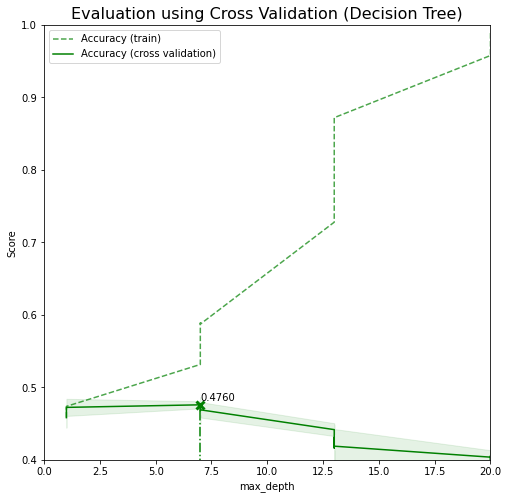

In [ ]:
plot_train_test_acc(results, scoring, title="Evaluation using Cross Validation (Decision Tree)", xlabel="max_depth", ylabel="Score", fig_size=(8,8), xlim=(0,20))

Accuracy:  0.4940991345397325
              precision    recall  f1-score   support

           A       0.46      0.51      0.49       393
           D       0.24      0.03      0.06       316
           H       0.53      0.74      0.62       562

    accuracy                           0.49      1271
   macro avg       0.41      0.43      0.39      1271
weighted avg       0.44      0.49      0.44      1271



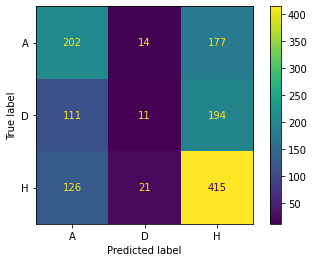

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['DT'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### Random Forest

In [ ]:
# Fit the model using training data
clf = fit_RF(X_train, y_train)
results = clf.cv_results_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


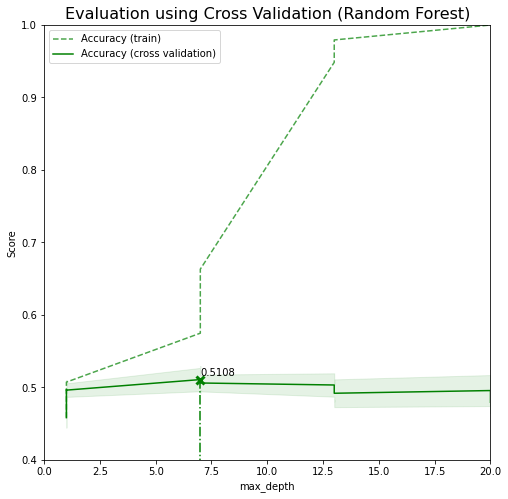

In [ ]:
plot_train_test_acc(results, scoring, title="Evaluation using Cross Validation (Random Forest)", xlabel="max_depth", ylabel="Score", fig_size=(8,8), xlim=(0,20))

Accuracy:  0.5192761605035405
              precision    recall  f1-score   support

           A       0.53      0.42      0.47       393
           D       0.00      0.00      0.00       316
           H       0.52      0.88      0.65       562

    accuracy                           0.52      1271
   macro avg       0.35      0.43      0.37      1271
weighted avg       0.39      0.52      0.43      1271



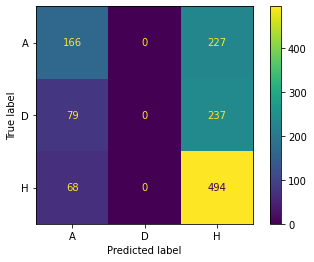

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['RF'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### K-Nearest Neighbours (KNN)

In [ ]:
# Fit the model using training data
clf = fit_KNN(X_train, y_train)
results = clf.cv_results_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


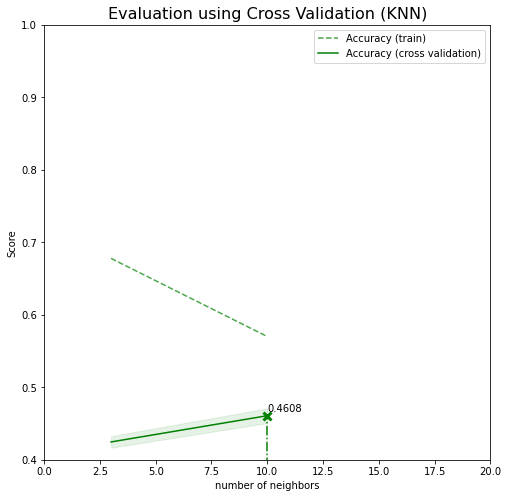

In [ ]:
plot_train_test_acc(results, scoring,param_x="param_n_neighbors", title="Evaluation using Cross Validation (KNN)", xlabel="number of neighbors", ylabel="Score", fig_size=(8,8), xlim=(0,20))

Accuracy:  0.46813532651455547
              precision    recall  f1-score   support

           A       0.45      0.47      0.46       393
           D       0.26      0.16      0.19       316
           H       0.54      0.65      0.59       562

    accuracy                           0.47      1271
   macro avg       0.42      0.42      0.41      1271
weighted avg       0.44      0.47      0.45      1271



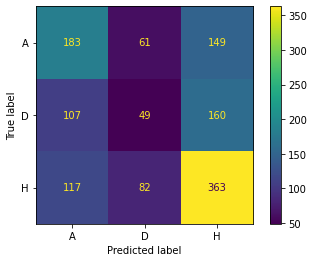

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['KNN'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### Support Vector Machine

In [ ]:
clf = fit_SVM(X_train, y_train)
results = clf.cv_results_

Fitting 5 folds for each of 11 candidates, totalling 55 fits


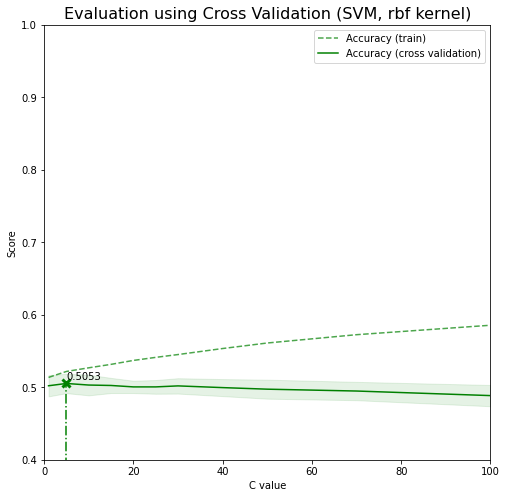

In [ ]:
plot_train_test_acc(results, scoring,param_x="param_C", title="Evaluation using Cross Validation (SVM, rbf kernel)", xlabel="C value", ylabel="Score", fig_size=(8,8), xlim=(0,40))

Accuracy:  0.5121951219512195
              precision    recall  f1-score   support

           A       0.52      0.43      0.47       393
           D       0.00      0.00      0.00       316
           H       0.51      0.86      0.64       562

    accuracy                           0.51      1271
   macro avg       0.34      0.43      0.37      1271
weighted avg       0.39      0.51      0.43      1271



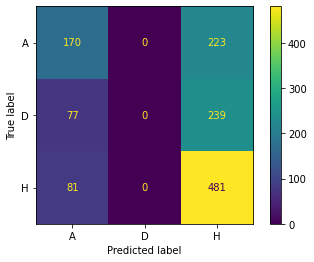

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['SVM'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### Summary of Results

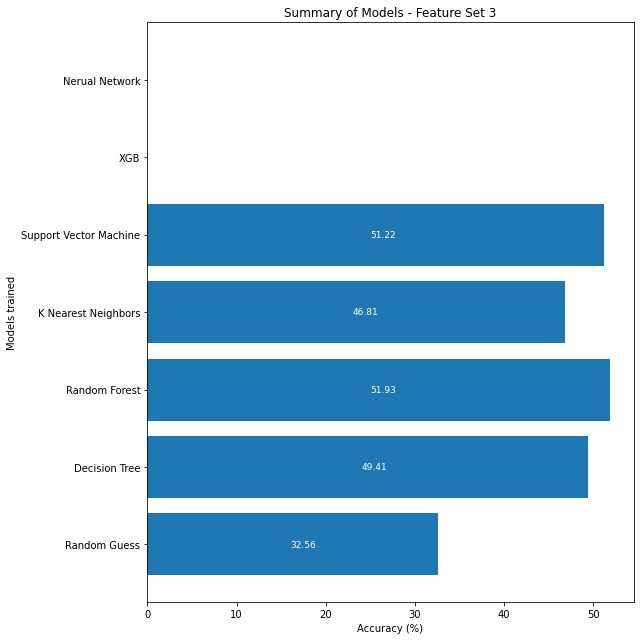

In [ ]:
# TODO(@Adam): Add histogram to compare accuracies of the differen models trained before (plus baseline)
summary_hist(title="Summary of Models - Feature Set 3", fig_size=(9, 9))

### **FEATURE SET 4** - Included averages of match statistics between the two specific target teams against ALL other teams across ONLY current season 

*SUMMARY ->* Here we aim to improve our previous score by adding changing the way we compute the average. These new past average stats are obtained by filtering the df_epl dataframe to get two filtered dataframes. One will include the matches played by HomeTeam at Home against ALL other teams in that specific season. The other will include the matches played by AwayTeam Away against ALL other teams in that specific season. Given these filtered dataframes we take an average of the columns (with stats) like HR, AR, etc. This will provide us with the past stats for games played between the two teams against all other teams in that specific season. We can then use these past average stats as features to input into the classifier. This should produce an improvement because recent season data should act as a better estimator of the result of current season games

#### Create Dataframe & Design Matrix

In [ ]:
# HELPER FUNCTIONS FOR CREATE_DF()
def get_season_start_date(date):
    if date.month <= 7:
        return datetime(date.year-1, 8, 1)
    return datetime(date.year-0, 8, 1)

def filter_dataframe_by_hometeam_recent_season(df, date, HomeTeam):
    # Convert the input string date into datetime
    date = pd.to_datetime(date, dayfirst=True)
    # Filter the dataframe to include only rows where Dateinput(first day of season) && HomeTeam=input(HomeTeam)
    df_filtered = df.copy()
    df_filtered = df_filtered[(df_filtered.Date<date) & (df_filtered.Date>get_season_start_date(date)) & (df_filtered.HomeTeam_Enc==HomeTeam)]
    # Return filtered dataframe
    return df_filtered

def filter_dataframe_by_awayteam_recent_season(df, date, AwayTeam):
    # Convert the input string date into datetime
    date = pd.to_datetime(date, dayfirst=True)
    # Filter the dataframe to include only rows where Dateinput(first day of season) && HomeTeam=input(HomeTeam)
    df_filtered = df.copy()
    df_filtered = df_filtered[(df_filtered.Date<date) & (df_filtered.Date>get_season_start_date(date)) & (df_filtered.AwayTeam_Enc==AwayTeam)]
    # Return filtered dataframe
    return df_filtered

# This function takes as input the filtered dataframe from previous cell, features to average and a dictionary,
# it then appends an average of each feature to the dictionary
def average_columns(avg_features, filtered_df):
    for feature in avg_features.keys():
        df_col_means = filtered_df[feature].mean()
        avg_features[feature].append(df_col_means)



# CREATE FEATURES & ADD TO ORIGINAL DATAFRAME
def create_df(df):
  df_final = df_epl.copy()
  # These are the features we want to get averages for home team
  avg_features_home = {
                      "FTHG": [],
                      "HTHG": [],
                      "HS"  : [],
                      "HST" : [],
                      "HF"  : [],
                      "HC"  : [],
                      "HY"  : [],
                      "HR"  : [],
                  }

  # These are the features we want to get averages for away team
  avg_features_away = {
                      "FTAG": [],
                      "HTAG": [],
                      "AS"  : [],
                      "AST" : [],
                      "AF"  : [],
                      "AC"  : [],
                      "AY"  : [],
                      "AR"  : []
                    }

  # Run the two functions on each row of the df_epl_train and fill the dictionary, For each row in the dataframe
  for index, row in df_final.iterrows():
      # Filter the dataframe to only show matches played between those teams and before the certain date
      df_epl_train_average_hometeam_recent_season = filter_dataframe_by_hometeam_recent_season(df_final, row["Date"],row["HomeTeam_Enc"])
      df_epl_train_average_awayteam_recent_season = filter_dataframe_by_awayteam_recent_season(df_final, row["Date"],row["AwayTeam_Enc"])
      # Get averages from the filtered dataframe and add the the dictionary
      average_columns(avg_features_home, df_epl_train_average_hometeam_recent_season)
      average_columns(avg_features_away, df_epl_train_average_awayteam_recent_season)

  for feature in avg_features_home.keys():
      # Get the list of averages for a certain feature from the dicitonary
      feature_vals = avg_features_home[feature]
      # Add the list of averages into the dataframe for that certain feature
      df_final[feature + "_AVG"] = feature_vals
      
  for feature in avg_features_away.keys():
      # Get the list of averages for a certain feature from the dicitonary
      feature_vals = avg_features_away[feature]
      # Add the list of averages into the dataframe for that certain feature
      df_final[feature + "_AVG"] = feature_vals

  # Drop any rows with nan
  return df_final.dropna()



# CODE TO CREATE DESIGN MATRIX
def create_design_matrix(df):
  X = df.loc[:,['Day', 'Month', 'HomeTeam_Enc', 'AwayTeam_Enc','FTHG_AVG','FTAG_AVG','HTHG_AVG','HTAG_AVG','HS_AVG','AS_AVG','HST_AVG','AST_AVG','HF_AVG','AF_AVG','HC_AVG','AC_AVG','HY_AVG','AY_AVG','HR_AVG','AR_AVG']].values
  # X = df.drop(['FTR', 'Date'], axis=1).values
  return X



# MAIN CODE
df_final = create_df(df_epl)
X = create_design_matrix(df_final)
y = df_final.loc[:,['FTR']].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

FTR_encoder = LabelEncoder()
y_train = FTR_encoder.fit_transform(y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Decision Tree Classifier

In [ ]:
# Fit the model using training data
clf = fit_DT(X_train, y_train)
results = clf.cv_results_

[1, 7, 13, 20]
Fitting 5 folds for each of 16 candidates, totalling 80 fits


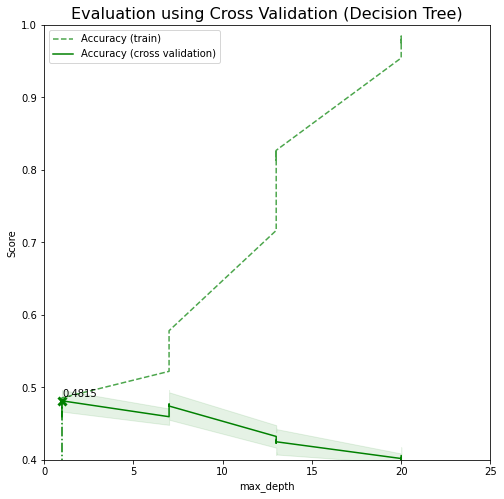

In [ ]:
plot_train_test_acc(results, scoring, title="Evaluation using Cross Validation (Decision Tree)", xlabel="max_depth", ylabel="Score", fig_size=(8,8), xlim=(0,25))

Accuracy:  0.4921286789869952
              precision    recall  f1-score   support

           A       0.44      0.40      0.42       430
           D       0.00      0.00      0.00       349
           H       0.51      0.80      0.62       682

    accuracy                           0.49      1461
   macro avg       0.32      0.40      0.35      1461
weighted avg       0.37      0.49      0.42      1461



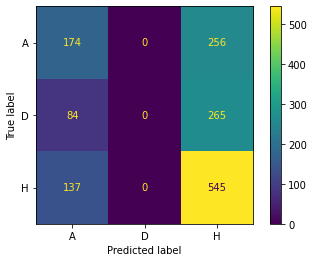

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['DT'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### Random Forest

In [ ]:
# Fit the model using training data
clf = fit_RF(X_train, y_train)
results = clf.cv_results_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


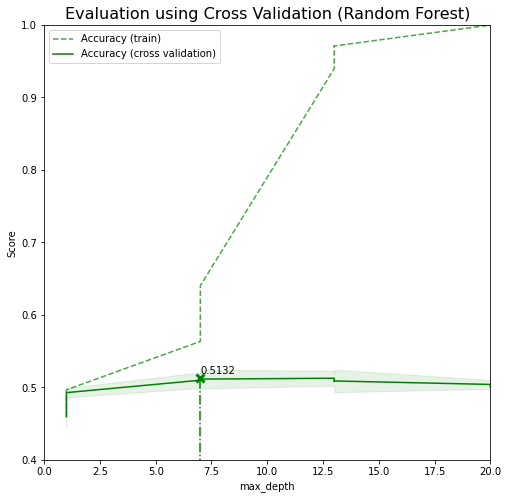

In [ ]:
plot_train_test_acc(results, scoring, title="Evaluation using Cross Validation (Random Forest)", xlabel="max_depth", ylabel="Score", fig_size=(8,8), xlim=(0,20))

Accuracy:  0.5222450376454483
              precision    recall  f1-score   support

           A       0.50      0.43      0.47       430
           D       0.25      0.01      0.01       349
           H       0.53      0.84      0.65       682

    accuracy                           0.52      1461
   macro avg       0.43      0.43      0.38      1461
weighted avg       0.46      0.52      0.44      1461



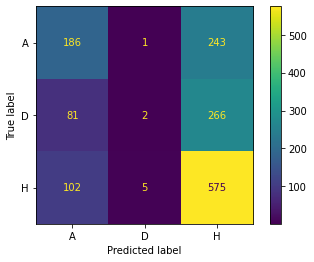

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['RF'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### K-Nearest Neighbours (KNN)

In [ ]:
# Fit the model using training data
clf = fit_KNN(X_train, y_train)
results = clf.cv_results_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


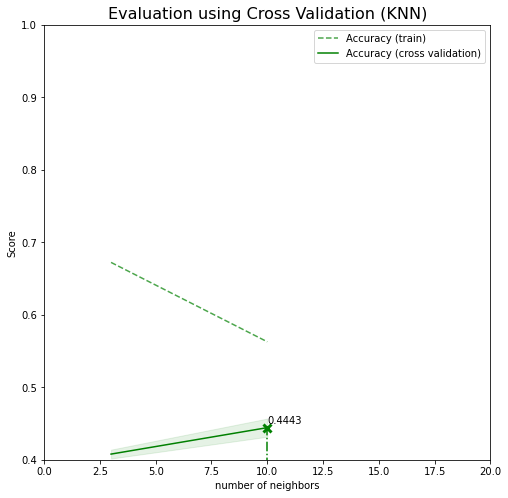

In [ ]:
plot_train_test_acc(results, scoring,param_x="param_n_neighbors", title="Evaluation using Cross Validation (KNN)", xlabel="number of neighbors", ylabel="Score", fig_size=(8,8), xlim=(0,20))

Accuracy:  0.4668035592060233
              precision    recall  f1-score   support

           A       0.43      0.42      0.42       430
           D       0.27      0.17      0.21       349
           H       0.54      0.65      0.59       682

    accuracy                           0.47      1461
   macro avg       0.41      0.41      0.41      1461
weighted avg       0.44      0.47      0.45      1461



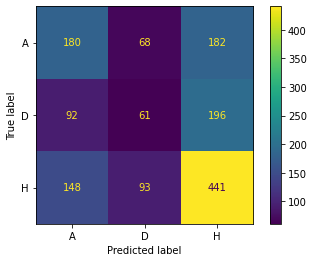

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['KNN'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### Support Vector Machine

In [ ]:
clf = fit_SVM(X_train, y_train)
results = clf.cv_results_

Fitting 5 folds for each of 11 candidates, totalling 55 fits


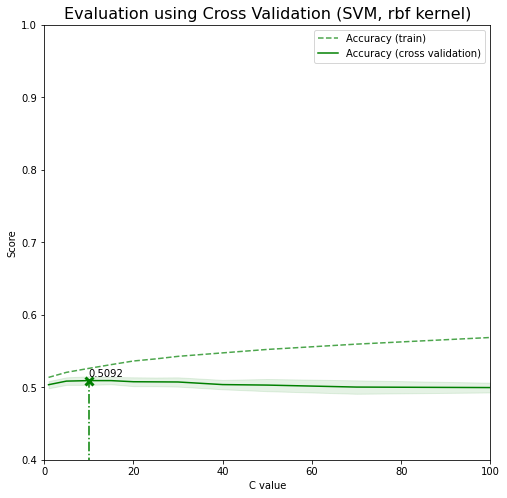

In [ ]:
plot_train_test_acc(results, scoring,param_x="param_C", title="Evaluation using Cross Validation (SVM, rbf kernel)", xlabel="C value", ylabel="Score", fig_size=(8,8), xlim=(0,40))

Accuracy:  0.5030800821355236
              precision    recall  f1-score   support

           A       0.48      0.33      0.39       430
           D       0.00      0.00      0.00       349
           H       0.51      0.87      0.64       682

    accuracy                           0.50      1461
   macro avg       0.33      0.40      0.34      1461
weighted avg       0.38      0.50      0.41      1461



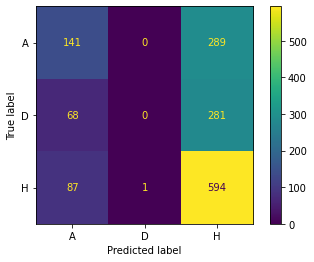

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['SVM'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### Summary Of Results

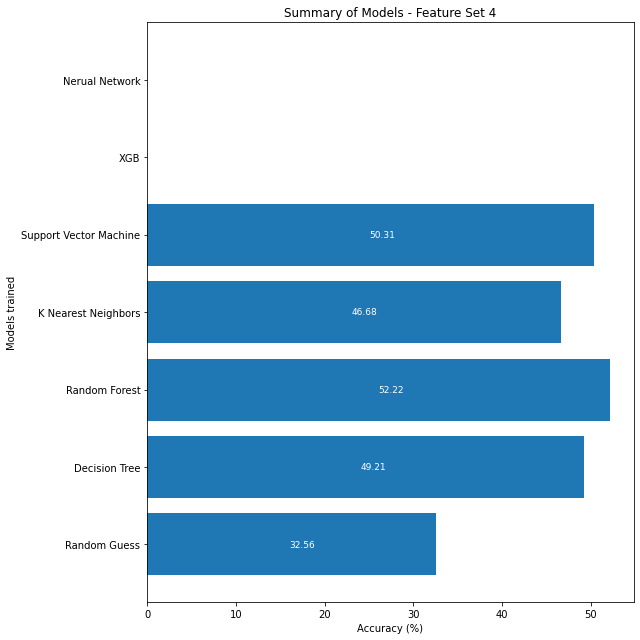

In [ ]:
# TODO(@Adam): Add histogram to compare accuracies of the differen models trained before (plus baseline)
summary_hist(title="Summary of Models - Feature Set 4", fig_size=(9, 9))

### **FEATURE SET 5** - Combines FEATURE SET 3 & 4

#### Create Dataframe & Design Matrix

In [ ]:
# HELPER FUNCTIONS FOR CREATE_DF()
def get_season_start_date(date):
    if date.month <= 7:
        return datetime(date.year-1, 8, 1)
    return datetime(date.year-0, 8, 1)

def filter_dataframe_by_bothteams_history(df, date, HomeTeam, AwayTeam):
    # Convert the input string date into datetime
    date = pd.to_datetime(date, dayfirst=True)

    # Filter the dataframe to include only rows where Date
    df_filtered = df.copy()
    df_filtered = df_filtered[(df_filtered.Date<date) & (df_filtered.HomeTeam_Enc==HomeTeam) & (df_filtered.AwayTeam_Enc==AwayTeam)]

    # Return filtered dataframe
    return df_filtered

def filter_dataframe_by_hometeam_recent_season(df, date, HomeTeam):
    # Convert the input string date into datetime
    date = pd.to_datetime(date, dayfirst=True)

    # Filter the dataframe to include only rows where Dateinput(first day of season) && HomeTeam=input(HomeTeam)
    df_filtered = df.copy()
    df_filtered = df_filtered[(df_filtered.Date<date) & (df_filtered.Date>get_season_start_date(date)) & (df_filtered.HomeTeam_Enc==HomeTeam)]

    # Return filtered dataframe
    return df_filtered

def filter_dataframe_by_awayteam_recent_season(df, date, AwayTeam):
    # Convert the input string date into datetime
    date = pd.to_datetime(date, dayfirst=True)

    # Filter the dataframe to include only rows where Dateinput(first day of season) && HomeTeam=input(HomeTeam)
    df_filtered = df.copy()
    df_filtered = df_filtered[(df_filtered.Date<date) & (df_filtered.Date>get_season_start_date(date)) & (df_filtered.AwayTeam_Enc==AwayTeam)]

    # Return filtered dataframe
    return df_filtered

# This function takes as input the filtered dataframe from previous cell, features to average and a dictionary,
# it then appends an average of each feature to the dictionary
def average_columns(avg_features, filtered_df):
    for feature in avg_features.keys():
        df_col_means = filtered_df[feature].mean()
        avg_features[feature].append(df_col_means)



# CREATE FEATURES & ADD TO ORIGINAL DATAFRAME
def create_df(df):
  df_final = df_epl.copy()
  # These are the features we want to get averages for both teams
  avg_features_both = {
                      "FTHG": [],
                      "FTAG": [],
                      "HTHG": [],
                      "HTAG": [],
                      "HS"  : [],
                      "AS"  : [],
                      "HST" : [],
                      "AST" : [],
                      "HF"  : [],
                      "AF"  : [],
                      "HC"  : [],
                      "AC"  : [],
                      "HY"  : [],
                      "AY"  : [],
                      "HR"  : [],
                      "AR"  : []
                  }

  # These are the features we want to get averages for home team
  avg_features_home = {
                      "FTHG": [],
                      "HTHG": [],
                      "HS"  : [],
                      "HST" : [],
                      "HF"  : [],
                      "HC"  : [],
                      "HY"  : [],
                      "HR"  : [],
                  }

  # These are the features we want to get averages for away team
  avg_features_away = {
                      "FTAG": [],
                      "HTAG": [],
                      "AS"  : [],
                      "AST" : [],
                      "AF"  : [],
                      "AC"  : [],
                      "AY"  : [],
                      "AR"  : []
                    }

  # Run the two functions on each row of the df_epl_train and fill the dictionary, For each row in the dataframe
  for index, row in df_final.iterrows():
      # Filter the dataframe to only show matches played between those teams and before the certain date
      df_epl_train_average_bothteams_history = filter_dataframe_by_bothteams_history(df_final, row["Date"],row["HomeTeam_Enc"],row["AwayTeam_Enc"])
      df_epl_train_average_hometeam_recent_season = filter_dataframe_by_hometeam_recent_season(df_final, row["Date"],row["HomeTeam_Enc"])
      df_epl_train_average_awayteam_recent_season = filter_dataframe_by_awayteam_recent_season(df_final, row["Date"],row["AwayTeam_Enc"])
      # Get averages from the filtered dataframe and add the the dictionary
      average_columns(avg_features_both, df_epl_train_average_bothteams_history)
      average_columns(avg_features_home, df_epl_train_average_hometeam_recent_season)
      average_columns(avg_features_away, df_epl_train_average_awayteam_recent_season)

  for feature in avg_features_both.keys():
      # Get the list of averages for a certain feature from the dicitonary
      feature_vals = avg_features_both[feature]
      # Add the list of averages into the dataframe for that certain feature
      df_final[feature + "_HISTORY"] = feature_vals

  for feature in avg_features_home.keys():
      # Get the list of averages for a certain feature from the dicitonary
      feature_vals = avg_features_home[feature]
      # Add the list of averages into the dataframe for that certain feature
      df_final[feature + "_AVG"] = feature_vals
      
  for feature in avg_features_away.keys():
      # Get the list of averages for a certain feature from the dicitonary
      feature_vals = avg_features_away[feature]
      # Add the list of averages into the dataframe for that certain feature
      df_final[feature + "_AVG"] = feature_vals

  # Drop any rows with nan
  return df_final.dropna()



# CODE TO CREATE DESIGN MATRIX
def create_design_matrix(df):
  X = df.loc[:,['Day', 'Month', 'HomeTeam_Enc', 'AwayTeam_Enc',
                              'HS_HISTORY','AS_HISTORY','HST_HISTORY','AST_HISTORY','HF_HISTORY','AF_HISTORY','HC_HISTORY','AC_HISTORY','HY_HISTORY','AY_HISTORY','HR_HISTORY','AR_HISTORY',
                              'HS_AVG','AS_AVG','HST_AVG','AST_AVG','HF_AVG','AF_AVG','HC_AVG','AC_AVG','HY_AVG','AY_AVG','HR_AVG','AR_AVG']].values
  # X = df.drop(['FTR', 'Date'], axis=1).values
  return X



# MAIN CODE
df_final = create_df(df_epl)
X = create_design_matrix(df_final)
y = df_final.loc[:,['FTR']].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

FTR_encoder = LabelEncoder()
y_train = FTR_encoder.fit_transform(y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Decision Tree Classifier

In [ ]:
# Fit the model using training data
clf = fit_DT(X_train, y_train)
results = clf.cv_results_

[1, 7, 14, 21, 28]
Fitting 5 folds for each of 25 candidates, totalling 125 fits


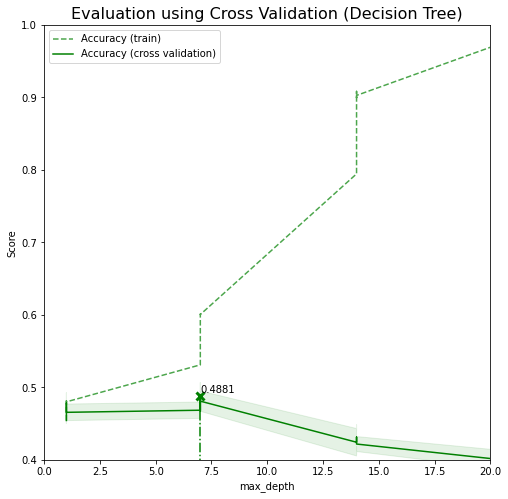

In [ ]:
plot_train_test_acc(results, scoring, title="Evaluation using Cross Validation (Decision Tree)", xlabel="max_depth", ylabel="Score", fig_size=(8,8), xlim=(0,20))

Accuracy:  0.5062447960033306
              precision    recall  f1-score   support

           A       0.44      0.53      0.48       347
           D       0.27      0.09      0.14       290
           H       0.58      0.71      0.64       564

    accuracy                           0.51      1201
   macro avg       0.43      0.44      0.42      1201
weighted avg       0.47      0.51      0.47      1201



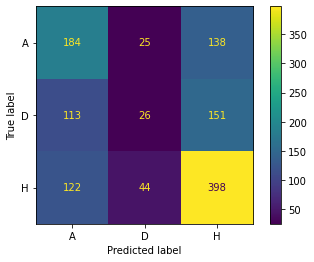

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['DT'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### Random Forest Classifier

In [ ]:
# Fit the model using training data
clf = fit_RF(X_train, y_train)
results = clf.cv_results_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


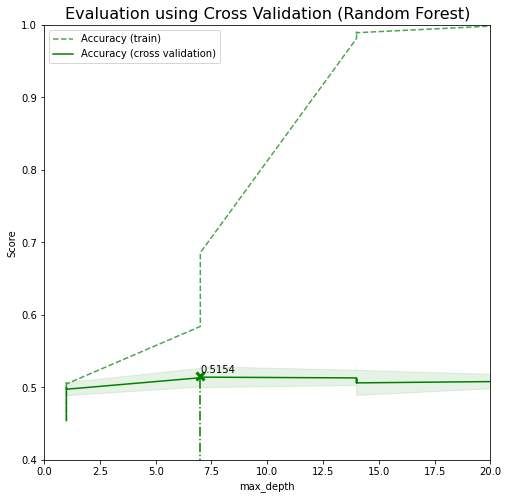

In [ ]:
plot_train_test_acc(results, scoring, title="Evaluation using Cross Validation (Random Forest)", xlabel="max_depth", ylabel="Score", fig_size=(8,8), xlim=(0,20))

Accuracy:  0.5512073272273106
              precision    recall  f1-score   support

           A       0.52      0.49      0.51       347
           D       0.25      0.01      0.02       290
           H       0.57      0.87      0.68       564

    accuracy                           0.55      1201
   macro avg       0.45      0.46      0.40      1201
weighted avg       0.48      0.55      0.47      1201



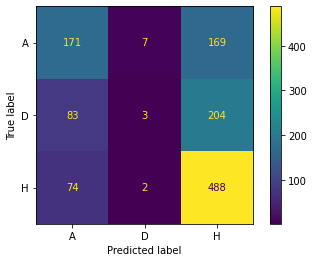

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['RF'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### K-Nearest Neighbours (KNN)

In [ ]:
# Fit the model using training data
clf = fit_KNN(X_train, y_train)
results = clf.cv_results_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


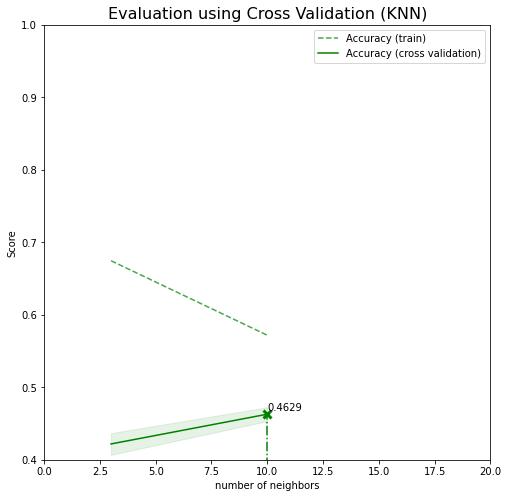

In [ ]:
plot_train_test_acc(results, scoring,param_x="param_n_neighbors", title="Evaluation using Cross Validation (KNN)", xlabel="number of neighbors", ylabel="Score", fig_size=(8,8), xlim=(0,20))

Accuracy:  0.46960865945045793
              precision    recall  f1-score   support

           A       0.43      0.50      0.46       347
           D       0.24      0.14      0.18       290
           H       0.56      0.62      0.59       564

    accuracy                           0.47      1201
   macro avg       0.41      0.42      0.41      1201
weighted avg       0.44      0.47      0.45      1201



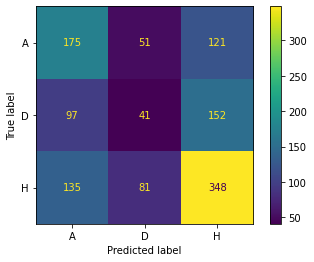

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['KNN'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### Support Vector Machine

In [ ]:
clf = fit_SVM(X_train, y_train)
results = clf.cv_results_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


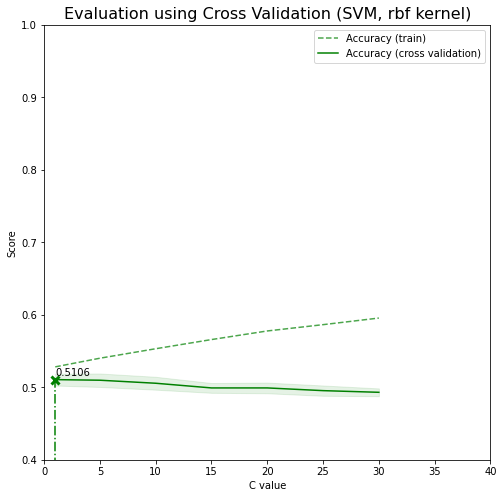

In [ ]:
plot_train_test_acc(results, scoring,param_x="param_C", title="Evaluation using Cross Validation (SVM, rbf kernel)", xlabel="C value", ylabel="Score", fig_size=(8,8), xlim=(0,40))

Accuracy:  0.5378850957535387
              precision    recall  f1-score   support

           A       0.53      0.44      0.48       347
           D       0.00      0.00      0.00       290
           H       0.54      0.87      0.67       564

    accuracy                           0.54      1201
   macro avg       0.36      0.44      0.38      1201
weighted avg       0.41      0.54      0.45      1201



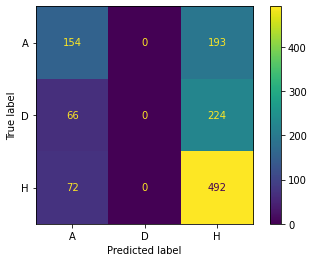

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['SVM'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### Summary Of Results

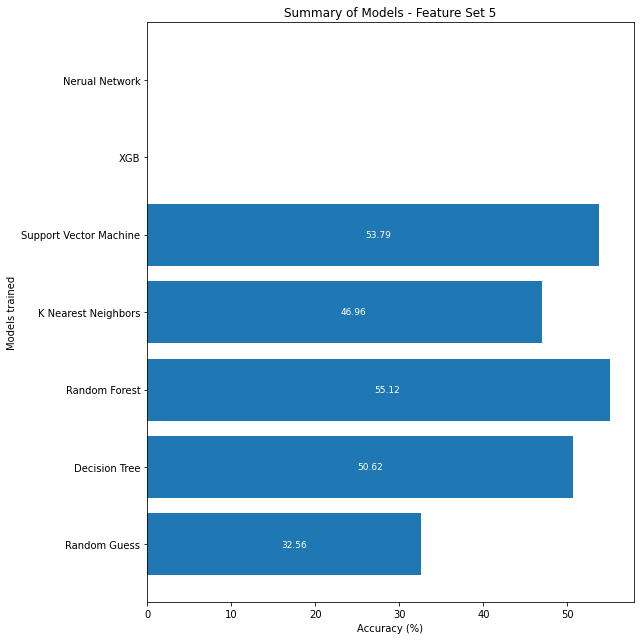

In [ ]:
# TODO(@Adam): Add histogram to compare accuracies of the differen models trained before (plus baseline)
summary_hist(title="Summary of Models - Feature Set 5", fig_size=(9, 9))

### **FEATURE SET 6** – Complex: Included Expected Goals, Number of Past Wins (Home & Away)

*SUMMARY ->* Here we aim to improve our previous score by adding some complex features to the design matrix. These features are Home/Away Team ratings, the expected/predicted goals for each team and the number of past wins in season for the home/away team.

The Home/Away team ratings are calculated by using a weighted sum of some of the averages we calculated in MODEL 4. The expected goals for each team are calculated using a polynomial regression classifier that is trained using again some of the features from the previous MODELS. The number of past wins are calculated by summing the number of wins by the team in the season. Once we calculate these extra features, we can then use them as extra inputs into the classifier.

NOTE: We must remove the rows in the dataframe where the average values of stats/features are 'nan'; we get these values because either its the teams first game of the season (hence no past data) OR because we have not got the past stats for these matches in the dataset. We cannot use the 'nan' values for the classifier training and hence have to remove these rows. We can then train a classifier using this final dataframe.

SO, In the final model/classifier, in the case where we DO NOT have these past stats of the teams playing, we need to switch back to using a variation of MODEL 2 which takes the 4 basic features: day, month, HomeTeam and AwayTeam. In the case where we DO have these past stats for the teams, we can use this model/classifier and input the features like HST_AVG. We would find these by using the filter_dataframe() and average_columns() functions to find them for any two specific teams playing each other on some date.

NOTE: This applies to MODEL 4 as well. A similar case applies to MODEL 3 BUT  in this case it happens when the two teams playing each other have not played each other before OR when we do not have this data in the dataset.

#### Create Dataframe & Design Matrix

In [ ]:
# HELPER FUNCTIONS FOR CREATE_DF()
def get_season_start_date(date):
    if date.month <= 7:
        return datetime(date.year-1, 8, 1)
    return datetime(date.year-0, 8, 1)

def filter_dataframe_by_bothteams_history(df, date, HomeTeam, AwayTeam):
    # Convert the input string date into datetime
    date = pd.to_datetime(date, dayfirst=True)

    # Filter the dataframe to include only rows where Date
    df_filtered = df.copy()
    df_filtered = df_filtered[(df_filtered.Date<date) & (df_filtered.HomeTeam_Enc==HomeTeam) & (df_filtered.AwayTeam_Enc==AwayTeam)]

    # Return filtered dataframe
    return df_filtered

def filter_dataframe_by_hometeam_recent_season(df, date, HomeTeam):
    # Convert the input string date into datetime
    date = pd.to_datetime(date, dayfirst=True)

    # Filter the dataframe to include only rows where Dateinput(first day of season) && HomeTeam=input(HomeTeam)
    df_filtered = df.copy()
    df_filtered = df_filtered[(df_filtered.Date<date) & (df_filtered.Date>get_season_start_date(date)) & (df_filtered.HomeTeam_Enc==HomeTeam)]

    # Return filtered dataframe
    return df_filtered

def filter_dataframe_by_awayteam_recent_season(df, date, AwayTeam):
    # Convert the input string date into datetime
    date = pd.to_datetime(date, dayfirst=True)

    # Filter the dataframe to include only rows where Dateinput(first day of season) && HomeTeam=input(HomeTeam)
    df_filtered = df.copy()
    df_filtered = df_filtered[(df_filtered.Date<date) & (df_filtered.Date>get_season_start_date(date)) & (df_filtered.AwayTeam_Enc==AwayTeam)]

    # Return filtered dataframe
    return df_filtered

# This function takes as input the filtered dataframe from previous cell, features to average and a dictionary,
# it then appends an average of each feature to the dictionary
def average_columns(avg_features, filtered_df):
    for feature in avg_features.keys():
        df_col_means = filtered_df[feature].mean()
        avg_features[feature].append(df_col_means)

# This function takes as input a filtered dataframe from previous cell, and a list,
# it then appends the % number of home/away wins in past
def find_number_of_wins(number_of_wins_list, filtered_df, team):
    df_filtered_ftr = filtered_df.copy()
    total_games = df_filtered_ftr.shape[0]
    if total_games == 0:
        number_of_wins_list.append(np.nan)
        return
    number_of_wins = df_filtered_ftr[(df_filtered_ftr.FTR==team)].shape[0]
    number_of_wins_list.append(number_of_wins/total_games)



# CREATE FEATURES & ADD TO ORIGINAL DATAFRAME
def create_df(df):
  df_final = df_epl.copy()
  # These are the features we want to get averages for both teams
  avg_features_both = {
                      "FTHG": [],
                      "FTAG": [],
                      "HTHG": [],
                      "HTAG": [],
                      "HS"  : [],
                      "AS"  : [],
                      "HST" : [],
                      "AST" : [],
                      "HF"  : [],
                      "AF"  : [],
                      "HC"  : [],
                      "AC"  : [],
                      "HY"  : [],
                      "AY"  : [],
                      "HR"  : [],
                      "AR"  : []
                  }

  # These are the features we want to get averages for home team
  avg_features_home = {
                      "FTHG": [],
                      "HTHG": [],
                      "HS"  : [],
                      "HST" : [],
                      "HF"  : [],
                      "HC"  : [],
                      "HY"  : [],
                      "HR"  : [],
                  }

  # These are the features we want to get averages for away team
  avg_features_away = {
                      "FTAG": [],
                      "HTAG": [],
                      "AS"  : [],
                      "AST" : [],
                      "AF"  : [],
                      "AC"  : [],
                      "AY"  : [],
                      "AR"  : []
                    }

  number_of_wins_HOME = []
  number_of_wins_AWAY = []

  # Run the two functions on each row of the df_epl_train and fill the dictionary, For each row in the dataframe
  for index, row in df_final.iterrows():
      # Filter the dataframe to only show matches played between those teams and before the certain date
      df_epl_train_average_bothteams_history = filter_dataframe_by_bothteams_history(df_final, row["Date"],row["HomeTeam_Enc"],row["AwayTeam_Enc"])
      df_epl_train_average_hometeam_recent_season = filter_dataframe_by_hometeam_recent_season(df_final, row["Date"],row["HomeTeam_Enc"])
      df_epl_train_average_awayteam_recent_season = filter_dataframe_by_awayteam_recent_season(df_final, row["Date"],row["AwayTeam_Enc"])
      # Get averages from the filtered dataframe and add the the dictionary
      average_columns(avg_features_both, df_epl_train_average_bothteams_history)
      average_columns(avg_features_home, df_epl_train_average_hometeam_recent_season)
      average_columns(avg_features_away, df_epl_train_average_awayteam_recent_season)
      # Get number_of_wins from the filtered dataframe and add to list
      find_number_of_wins(number_of_wins_HOME, df_epl_train_average_hometeam_recent_season, "H")
      find_number_of_wins(number_of_wins_AWAY, df_epl_train_average_awayteam_recent_season, "A")

  for feature in avg_features_both.keys():
      # Get the list of averages for a certain feature from the dicitonary
      feature_vals = avg_features_both[feature]
      # Add the list of averages into the dataframe for that certain feature
      df_final[feature + "_HISTORY"] = feature_vals

  for feature in avg_features_home.keys():
      # Get the list of averages for a certain feature from the dicitonary
      feature_vals = avg_features_home[feature]
      # Add the list of averages into the dataframe for that certain feature
      df_final[feature + "_AVG"] = feature_vals
      
  for feature in avg_features_away.keys():
      # Get the list of averages for a certain feature from the dicitonary
      feature_vals = avg_features_away[feature]
      # Add the list of averages into the dataframe for that certain feature
      df_final[feature + "_AVG"] = feature_vals

  # Add the past % number of wins
  df_final["HW_AVG"] = number_of_wins_HOME
  df_final["AW_AVG"] = number_of_wins_AWAY

  df_final = df_final.dropna()

  # Here we aim to create a 'expected or predicted goals for a HomeTeam' feature based upon the HomeTeamRating, 
  # and also the past wins, losses and draws, our outputs will be full time goals(FTHG). Similar for Away.
  min_mse_home = float('inf')
  min_mse_away = float('inf')

  # Create the design matrix
  X_H = df_final.loc[:,['Day', 'Month', 'HomeTeam_Enc', 'FTHG_AVG', 'HTHG_AVG', 'HS_AVG']].values
  y_H = df_final.loc[:,'FTHG'].values
  X_H_train, X_H_test, y_H_train, y_H_test = model_selection.train_test_split(X_H, y_H, test_size=0.2, random_state=20)

  # Similar idea for AwayTeam
  X_A = df_final.loc[:,['Day', 'Month', 'AwayTeam_Enc', 'FTAG_AVG', 'HTAG_AVG', 'AS_AVG']].values
  y_A = df_final.loc[:,'FTAG'].values
  X_A_train, X_A_test, y_A_train, y_A_test = model_selection.train_test_split(X_A, y_A, test_size=0.2, random_state=20)

  # Here we use a polynomial regression classifier - and select best one:
  for i in range(1,5):
      # Select order
      poly = PolynomialFeatures(degree=i)

      # Transform the features
      X_H_train_transform = poly.fit_transform(X_H_train)
      X_H_test_transform = poly.fit_transform(X_H_test)

      LR_Model_HOME_EG = LinearRegression()
      # Fit the model using training data
      LR_Model_HOME_EG.fit(X_H_train_transform, y_H_train)
      # Make predictions using the model we have created
      LR_H_predictions_test = LR_Model_HOME_EG.predict(X_H_test_transform)
      # Check the mean square error(MSE) for HomeTeam Expected Goals
      print(i, mean_squared_error(LR_H_predictions_test, y_H_test))

      # Transform the features
      X_A_train_transform = poly.fit_transform(X_A_train)
      X_A_test_transform = poly.fit_transform(X_A_test)

      LR_Model_AWAY_EG = LinearRegression()
      # Fit the model using training data
      LR_Model_AWAY_EG.fit(X_A_train_transform, y_A_train)
      # Make predictions using the model we have created
      LR_A_predictions_test = LR_Model_AWAY_EG.predict(X_A_test_transform)
      # Check the mean square error(MSE) for AwayTeam Expected Goals
      # print(i, mean_squared_error(LR_A_predictions_test, y_A_test))

      curr_mse_home = mean_squared_error(LR_H_predictions_test, y_H_test)
      curr_mse_away = mean_squared_error(LR_A_predictions_test, y_A_test)
      
      if curr_mse_home < min_mse_home:
          best_poly1 = poly
          best_model_home = LR_Model_HOME_EG
          min_mse_home = curr_mse_home
      
      if curr_mse_away < min_mse_away:
          best_poly2 = poly
          best_model_away = LR_Model_AWAY_EG
          min_mse_away = curr_mse_away

  # Using the two regression classfiers above, predict the number of goals that 
  # the Home and Away teams will hit for each row in the dataframe:
  HomeExGoals = []
  AwayExGoals = []
  # For each row, predict the home and away expected goals
  for index, row in df_final.iterrows():
      X_Home_features = np.array([[row["Day"],row["Month"],row["HomeTeam_Enc"],row["FTHG_AVG"],row["HTHG_AVG"],row["HS_AVG"]]])
      X_Away_features = np.array([[row["Day"],row["Month"],row["AwayTeam_Enc"],row["FTAG_AVG"],row["HTAG_AVG"],row["AS_AVG"]]])
      # Transform features since we use polynomial regression
      X_Home_features_transform = best_poly1.fit_transform(X_Home_features)
      X_Away_features_transform = best_poly2.fit_transform(X_Away_features)
      # Use the best polynomial classifier - Note the prediction is a 1 by 1 vector
      ex_home_goals = best_model_home.predict(X_Home_features_transform)[0]
      ex_away_goals = best_model_away.predict(X_Away_features_transform)[0]
      # Add prediciton to list
      HomeExGoals.append(ex_home_goals)
      AwayExGoals.append(ex_away_goals)

  # Add this data into the final dataframe
  df_final["Ex_Goals_Home"] = HomeExGoals
  df_final["Ex_Goals_Away"] = AwayExGoals

  # Drop any rows with nan
  return df_final



# CODE TO CREATE DESIGN MATRIX
def create_design_matrix(df):
  X = df.loc[:,['Day', 'Month', 'HomeTeam_Enc', 'AwayTeam_Enc',
                              'HS_HISTORY','AS_HISTORY','HST_HISTORY','AST_HISTORY','HF_HISTORY','AF_HISTORY','HC_HISTORY','AC_HISTORY','HY_HISTORY','AY_HISTORY','HR_HISTORY','AR_HISTORY',
                              'HS_AVG','AS_AVG','HST_AVG','AST_AVG','HF_AVG','AF_AVG','HC_AVG','AC_AVG','HY_AVG','AY_AVG','HR_AVG','AR_AVG','HW_AVG','AW_AVG','Ex_Goals_Home','Ex_Goals_Away']].values
  # X = df.drop(['FTR', 'Date'], axis=1).values
  return X



# MAIN CODE
df_final = create_df(df_epl)
X = create_design_matrix(df_final)
y = df_final.loc[:,['FTR']].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

FTR_encoder = LabelEncoder()
y_train = FTR_encoder.fit_transform(y_train);

1 1.5703161278928965
2 1.55917101860113
3 1.5440265254742451
4 1.595503490607686


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Decision Tree Classifier

In [ ]:
# Fit the model using training data
clf = fit_DT(X_train, y_train)
results = clf.cv_results_

[1, 7, 13, 19, 25, 32]
Fitting 5 folds for each of 36 candidates, totalling 180 fits


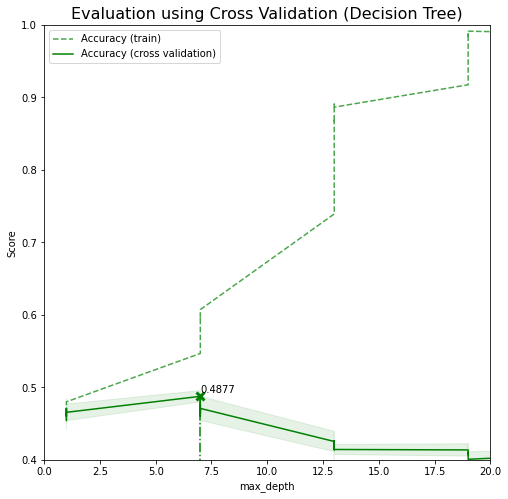

In [ ]:
plot_train_test_acc(results, scoring, title="Evaluation using Cross Validation (Decision Tree)", xlabel="max_depth", ylabel="Score", fig_size=(8,8), xlim=(0,20))

Accuracy:  0.5312239800166528
              precision    recall  f1-score   support

           A       0.50      0.45      0.47       347
           D       0.27      0.04      0.08       290
           H       0.56      0.83      0.67       564

    accuracy                           0.53      1201
   macro avg       0.44      0.44      0.41      1201
weighted avg       0.47      0.53      0.47      1201



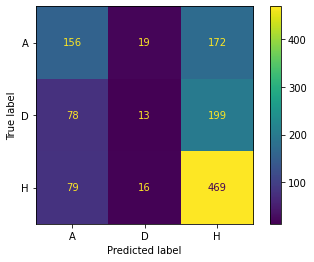

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['DT'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### Random Forest Classifier

In [ ]:
# Fit the model using training data
clf = fit_RF(X_train, y_train)
results = clf.cv_results_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


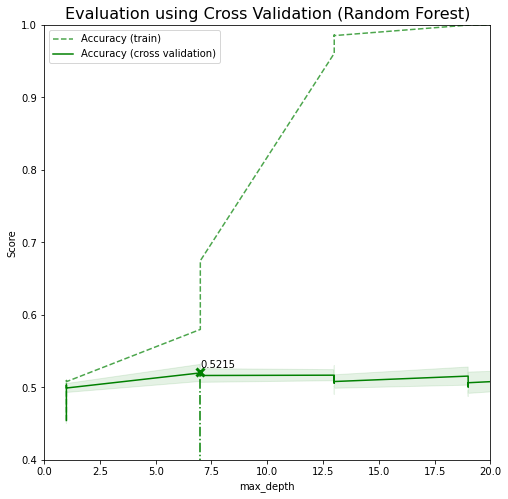

In [ ]:
plot_train_test_acc(results, scoring, title="Evaluation using Cross Validation (Random Forest)", xlabel="max_depth", ylabel="Score", fig_size=(8,8), xlim=(0,20))

Accuracy:  0.5462114904246461
              precision    recall  f1-score   support

           A       0.52      0.50      0.51       347
           D       0.08      0.00      0.01       290
           H       0.56      0.85      0.68       564

    accuracy                           0.55      1201
   macro avg       0.39      0.45      0.40      1201
weighted avg       0.44      0.55      0.47      1201



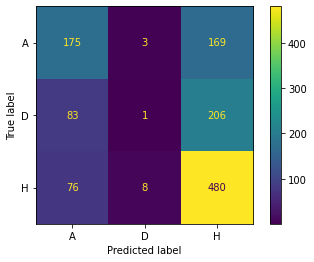

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['RF'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### K-Nearest Neighbours (KNN)

In [ ]:
# Fit the model using training data
clf = fit_KNN(X_train, y_train)
results = clf.cv_results_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


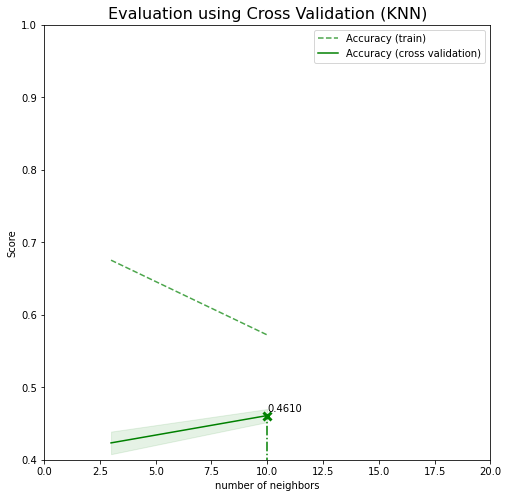

In [ ]:
plot_train_test_acc(results, scoring,param_x="param_n_neighbors", title="Evaluation using Cross Validation (KNN)", xlabel="number of neighbors", ylabel="Score", fig_size=(8,8), xlim=(0,20))

Accuracy:  0.46544546211490423
              precision    recall  f1-score   support

           A       0.43      0.50      0.46       347
           D       0.23      0.13      0.17       290
           H       0.56      0.62      0.58       564

    accuracy                           0.47      1201
   macro avg       0.40      0.42      0.40      1201
weighted avg       0.44      0.47      0.45      1201



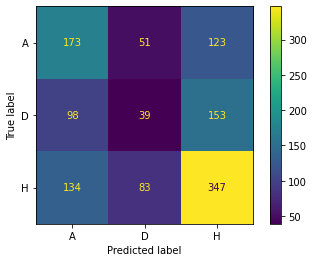

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['KNN'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### Support Vector Machine

In [ ]:
clf = fit_SVM(X_train, y_train)
results = clf.cv_results_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


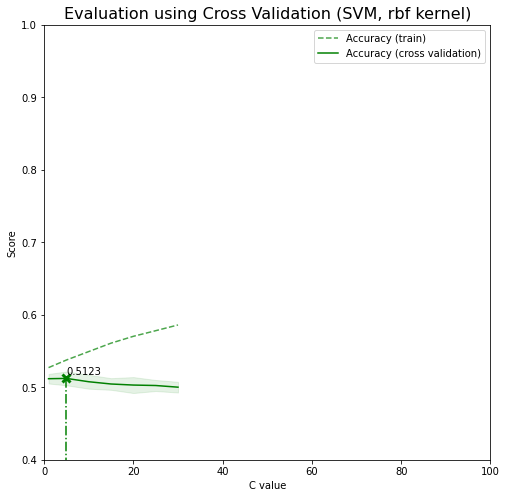

In [ ]:
plot_train_test_acc(results, scoring,param_x="param_C", title="Evaluation using Cross Validation (SVM, rbf kernel)", xlabel="C value", ylabel="Score", fig_size=(8,8), xlim=(0,100))

Accuracy:  0.5428809325562032
              precision    recall  f1-score   support

           A       0.53      0.46      0.49       347
           D       0.00      0.00      0.00       290
           H       0.55      0.88      0.67       564

    accuracy                           0.54      1201
   macro avg       0.36      0.44      0.39      1201
weighted avg       0.41      0.54      0.46      1201



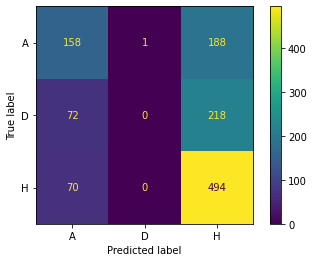

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['SVM'] = round(accuracy_score(y_test,y_pred)*100, 2)

#### Summary Of Results

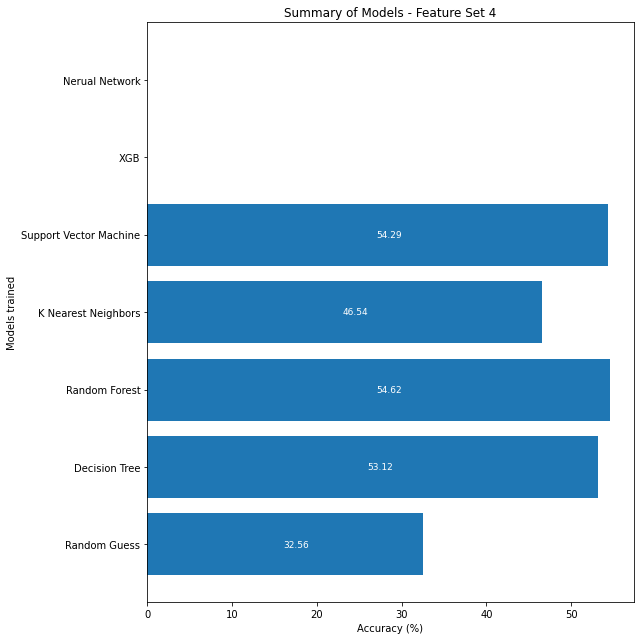

In [ ]:
# TODO(@Adam): Add histogram to compare accuracies of the differen models trained before (plus baseline)
summary_hist(title="Summary of Models - Feature Set 4", fig_size=(9, 9))